<a href="https://colab.research.google.com/github/ShaunakSen/Deep-Learning/blob/master/COMP6248_1_1_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Linear Regression

In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

## Getting started 

At its heart, PyTorch is just a library for manipulating tensors. We're going to start learning how to use 
PyTorch by looking at how we can implement simple linear regression. 

Code speaks better than words, so lets start by looking at a bit of pytorch code to generate some 2d data to regress:

In [99]:
import torch

# Generate some data points on a straight line perturbed with Gaussian noise
N = 1000 # number of points
theta_true = torch.Tensor([[1.5], [2.0]]) # true parameters of the line: slope = 1.5, intercept = 20

# print (theta_true.shape)

# theta_true shape: 2x1
# X shape: Nx2
# X @ theta_true shape: Nx1

# rand(): Returns a tensor filled with random numbers from a uniform distribution

X = torch.rand(N, 2)

# make 1st col = 1 for all the rows
X[:, 1] = 1.0

# torch.randn() Returns a tensor filled with random numbers from a normal distribution with mean `0` and variance `1`

y = X @ theta_true + 0.1 * torch.randn(N, 1) # Note that just like in numpy '@' represents matrix multiplication and A@B is equivalent to torch.mm(A, B) 

print(y[:5])



tensor([[3.1235],
        [2.2310],
        [2.3902],
        [2.0669],
        [3.2297]])


The above code generates $(x,y)$ data according to $y = 1.5x + 2$, with the $x$'s chosen from a uniform distribution. The $y$'s are additionally purturbed by adding an amount $0.1z$, where $z\sim \mathcal{N}(0,1)$ is a sample from a standard normal distribution. 

Note that we represent our $x$'s as a two-dimensional (row) vector with a 1 in the second element so that the offset can be rolled into the matrix multiplication for efficiency:

\begin{align}
    y &= \mathbf{X}\begin{bmatrix}
           1.5 \\
           2
         \end{bmatrix}
  \end{align}

Let's use `matplotlib` to draw a scatter so we can be sure of what our data looks like:

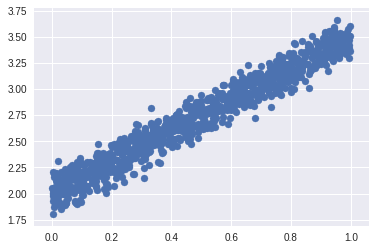

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.scatter(X[:,0].numpy(), y.numpy())
plt.show()

__Make sure you understand how the code above is generating data; feel free to change the parameters to see what effect they have.__

Now, lets consider the situation where we have been given the tensors $X$ and $y$ and wish to compute the regression parameters. Our model looks like $\mathbf{y} = \mathbf{X\theta}$, and we wish to recover the parameters $\theta$. 

As the problem is both overcomplete (only two data pairs are required to find $\theta$), and the data is noisy, we can use the Moore-Penrose Pseudoinverse to find the least-squares solution to $\theta$: $\theta = \mathbf{X^+y}$. PyTorch has a built-in pseudoinverse method (`pinverse`) that can do all the work for us:

In [101]:
# direct solution using moore-penrose pseudo inverse
X_inv = torch.pinverse(X)

print(X_inv.shape)

theta_pinv = torch.mm(X_inv, y)
print(theta_pinv)

torch.Size([2, 1000])
tensor([[1.4958],
        [2.0058]])


Running the above code should give you a solution vector for $\theta$ that is very similar to the true parameter vector (`theta_true`). 

## Exercise: computing the pseudoinverse from the Singular Value Decomposition.

The standard way of computing the pseudoinverse is by using the Singular Value Decomposition (SVD). The SVD is defined as: $\mathbf{X} = \mathbf{U}\Sigma\mathbf{V}^\top$. The pseudoinverse is thus $\mathbf{X}^+ = \mathbf{V}\Sigma^{-1}\mathbf{U}^\top$ where $\Sigma^{-1}$ is a diagonal matrix in which the reciprocal of the corresponding non-zero elements in $\Sigma$ has been taken.

__Use the code block below to compute the parameter vector using the SVD directly rather than the through the `pinverse` method.__ You need to store your manually computed pseudoinverse in `X_inv_svd`. Useful methods will be `torch.svd()` to compute the SVD, `[Tensor].t()` to transpose a matrix and `torch.diag()` to form a diagonal matrix from a vector.

In [102]:
# YOUR CODE HERE
# raise NotImplementedError()

X_svd = torch.svd(X)

# print(X_svd[0].shape, X_svd[1].shape, X_svd[2].shape)

U = X_svd[0]
sigma = X_svd[1]
V = X_svd[2]

sigma_diag = torch.diag(sigma) 
sigma_diag_inv = torch.inverse(sigma_diag)
U_t = U.t()


X_inv_svd = V.mm(sigma_diag_inv.mm(U_t))

# print (X_inv_svd.shape)
theta_pinv_svd = torch.mm(X_inv_svd, y)

print(theta_pinv_svd)

tensor([[1.4958],
        [2.0058]])


In [0]:
assert(torch.all(torch.lt(torch.abs(torch.add(theta_pinv, -theta_pinv_svd)), 1e-6)))

## Gradient based Linear Regression

Fundamentally, with linear regression we are trying to find a solution vector, $theta$ that minimises $f(\theta) = 0.5\|\mathbf{X}\theta - \mathbf{y}\|_2^2$. 

We've already seen how this can be minimised directly using the pseudoinverse, but it could also be minimised by using gradient descent: $\theta \gets \theta - \alpha f'(\theta)$. (_Interesting aside_: SVD (and thus the pseudoinverse) can also be solved using gradient methods - in fact this becomes the only practical way for really large matrices.).

__Use the following block to derive and write down the gradient, $f'(\theta)$, of $f(\theta)$__. Note that you can insert latex code by wrapping expressions in dollar symbols.

**Deriving the gradient: **

$$f(\theta ) = 0.5\left \| \mathbf{X\theta - y} \right \|_{2}^{2} = 0.5(\mathbf{X}\theta - y)(\mathbf{X}\theta - y)^{T}$$

$$\therefore {f}'(\theta) = 0.5 \times 2\times \mathbf{X}^{T}.(\mathbf{X}\theta - y) = \mathbf{X}^{T}.(\mathbf{X}\theta - y)$$

__Now complete the following code block to implement your gradient as pytorch code:__

In [0]:
def linear_regression_loss_grad(theta, X, y):
    # theta, X and y have the same shape as used previously
    # YOUR CODE HERE
    
    grad = X.t().mm(X.mm(theta)-y)

    
    # raise NotImplementedError()
    return grad

In [0]:
assert(linear_regression_loss_grad(torch.zeros(2,1), X, y).shape == (2,1))


Now we can plug that gradient function into a basic gradient descent solver and check that the solution is close to what we get with the pseudoinverse:

In [106]:
alpha = 0.001
theta = torch.Tensor([[0], [0]])
for e in range(0, 200):
    gr = linear_regression_loss_grad(theta, X, y)
    theta -= alpha * gr

print(theta)

# theta is almost exactly equal to that computed using pseudoinverse

tensor([[1.4958],
        [2.0058]])


## Real data

Doing linear regression on synthetic data is a great way to understand how PyTorch works, but it isn't quite as satisfying as working with a real dataset. Let's now apply or understanding of computing linear regression parameters to a dataset of house prices in Boston.

We'll load the dataset using scikit-learn and perform some manipulations in the following code block:

In [141]:
from sklearn.datasets import load_boston

X, y = tuple(torch.Tensor(z) for z in load_boston(True)) #convert to pytorch Tensors
X = X[:, [2,5]] # We're just going to use features 2 and 5, rather than using all of of them
X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # append a column of 1's to the X's
y = y.reshape(-1, 1) # reshape y into a column vector
print('X:', X.shape)
print('y:', y.shape)

# We're also going to break the data into a training set for computing the regression parameters
# and a test set to evaluate the predictive ability of those parameters
perm = torch.randperm(y.shape[0])
X_train = X[perm[0:253], :]
y_train = y[perm[0:253]]
X_test = X[perm[253:], :]
y_test = y[perm[253:]]

X: torch.Size([506, 3])
y: torch.Size([506, 1])


__Use the following code block to compute the regression parameters using the training data in the variable `theta` by solving using the pseudoinverse directly:__

In [142]:
# compute the regression parameters in variable theta
# YOUR CODE HERE


X_train_inv = torch.pinverse(X_train)

theta = torch.mm(X_train_inv, y_train)

print(theta)

tensor([[ -0.4112],
        [  7.4687],
        [-20.4261]])


We can now print out the error achieved on the test set, as well as the parameter vector:

In [143]:
assert(theta.shape == (3,1))

print("Theta: ", theta.t())

# Measures the element-wise mean squared error

print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta, y_test))

Theta:  tensor([[ -0.4112,   7.4687, -20.4261]])
MSE of test data:  tensor(49.2230)


Now let's try using gradient descent:

In [149]:
alpha_values = [0.000006, 0.00001, 0.00003, 0.00004]
theta_gd = torch.rand((X_train.shape[1], 1))


mse_for_each_iterations = []

mse_for_alpha = []

num_iters = 100

for alpha in alpha_values:
  
  # re initialize theta to random values
  
  theta_gd = torch.rand((X_train.shape[1], 1))
  
  mse_for_each_iterations = []

  for e in range(0, num_iters):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr
    # compute MSE for the current theta_gd
    mse = torch.nn.functional.mse_loss(X_train @ theta_gd, y_train)
    mse_for_each_iterations.append(mse)
  
  mse_for_alpha.append(mse_for_each_iterations)
    

print(mse_for_alpha[3])
print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

[tensor(264.0038), tensor(227.4178), tensor(198.5915), tensor(175.8843), tensor(158.0024), tensor(143.9255), tensor(132.8493), tensor(124.1392), tensor(117.2952), tensor(111.9225), tensor(107.7103), tensor(104.4132), tensor(101.8378), tensor(99.8316), tensor(98.2743), tensor(97.0708), tensor(96.1465), tensor(95.4424), tensor(94.9121), tensor(94.5188), tensor(94.2335), tensor(94.0335), tensor(93.9009), tensor(93.8213), tensor(93.7839), tensor(93.7794), tensor(93.8013), tensor(93.8436), tensor(93.9024), tensor(93.9742), tensor(94.0562), tensor(94.1464), tensor(94.2430), tensor(94.3448), tensor(94.4507), tensor(94.5600), tensor(94.6718), tensor(94.7859), tensor(94.9018), tensor(95.0190), tensor(95.1373), tensor(95.2567), tensor(95.3768), tensor(95.4978), tensor(95.6193), tensor(95.7414), tensor(95.8638), tensor(95.9867), tensor(96.1100), tensor(96.2337), tensor(96.3577), tensor(96.4820), tensor(96.6066), tensor(96.7315), tensor(96.8567), tensor(96.9822), tensor(97.1079), tensor(97.2339), 

__Use the following block to note down any observations you can make about the choice of learning rate and number of iterations in the above code. What factors do you think influence the choice?__



- As we increase the number of iterations from 10,000 to 100,000 the MSE decreases and tends to the MSE found using pseudoinverse

- The `theta_gd` also tends to be closer to the `theta` found using pseudoinverse

**Plot between MSE and num_iter for various LR to choose the best one**

The size of the data is an important factor while chosing LR

![](https://cdn-images-1.medium.com/max/800/0*uIa_Dz3czXO5iWyI.)

Keeping the above plot in mind we can try and generate a similar plot for various values of learning rate

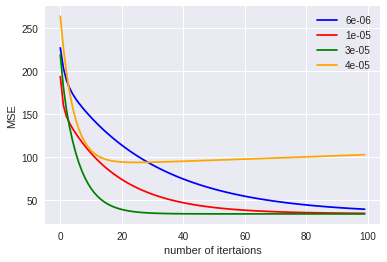

In [151]:
# YOUR CODE HERE
fig, ax = plt.subplots()


colors = ['blue', 'red' , 'green', 'orange']

for index in range(len(alpha_values)):
  ax.plot(list(range(num_iters)), mse_for_alpha[index], label = float(alpha_values[index]), color = colors[index])
  
ax.legend()
plt.xlabel("number of itertaions")
plt.ylabel("MSE")
plt.show()  

We use 4 values of alpha:

- 0.000006
- 0.00001
- 0.00003
- 0.00004

We plot the MSE on train set over the number of iterations(100) 

We find that **0.00001** is a good learning rate (red curve)

The green curve with alpha = 0.00003 has a high learning rate and converges too quickly

The orange curve with alpha = 0.00004 has a very high learning rate and converges very quickly and then the loss increases

The blue curve with alpha = 0.000006 has a very low learning rate and does not converge till 100 iterations

Now that we have found the optimal alpha we re train the model by varying the number of iterations:

In [153]:
alpha = 0.00001
theta_gd = torch.rand((X_train.shape[1], 1))



num_iters = 100000

 
  
theta_gd = torch.rand((X_train.shape[1], 1))
  

for e in range(0, num_iters):
  gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
  theta_gd -= alpha * gr
  

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[ -0.4331,   7.0077, -17.2707]])
MSE of test data:  tensor(49.6022)


Finally, just so we can visualise what our model has learned, we can plot the predicted house prices (from both the direct solution and from gradient descent) along with the true value for each of the houses in the test set (ordered by increasing true value):

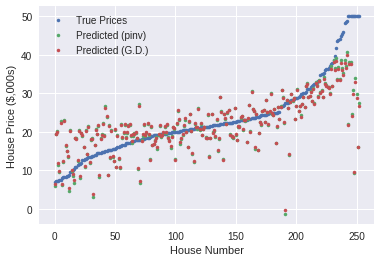

In [154]:
perm = torch.argsort(y_test, dim=0)
plt.plot(y_test[perm[:,0]].numpy(), '.', label='True Prices')
plt.plot((X_test[perm[:,0]] @ theta).numpy(), '.', label='Predicted (pinv)')
plt.plot((X_test[perm[:,0]] @ theta_gd).numpy(), '.', label='Predicted (G.D.)')
plt.xlabel('House Number')
plt.ylabel('House Price ($,000s)')
plt.legend()
plt.show()